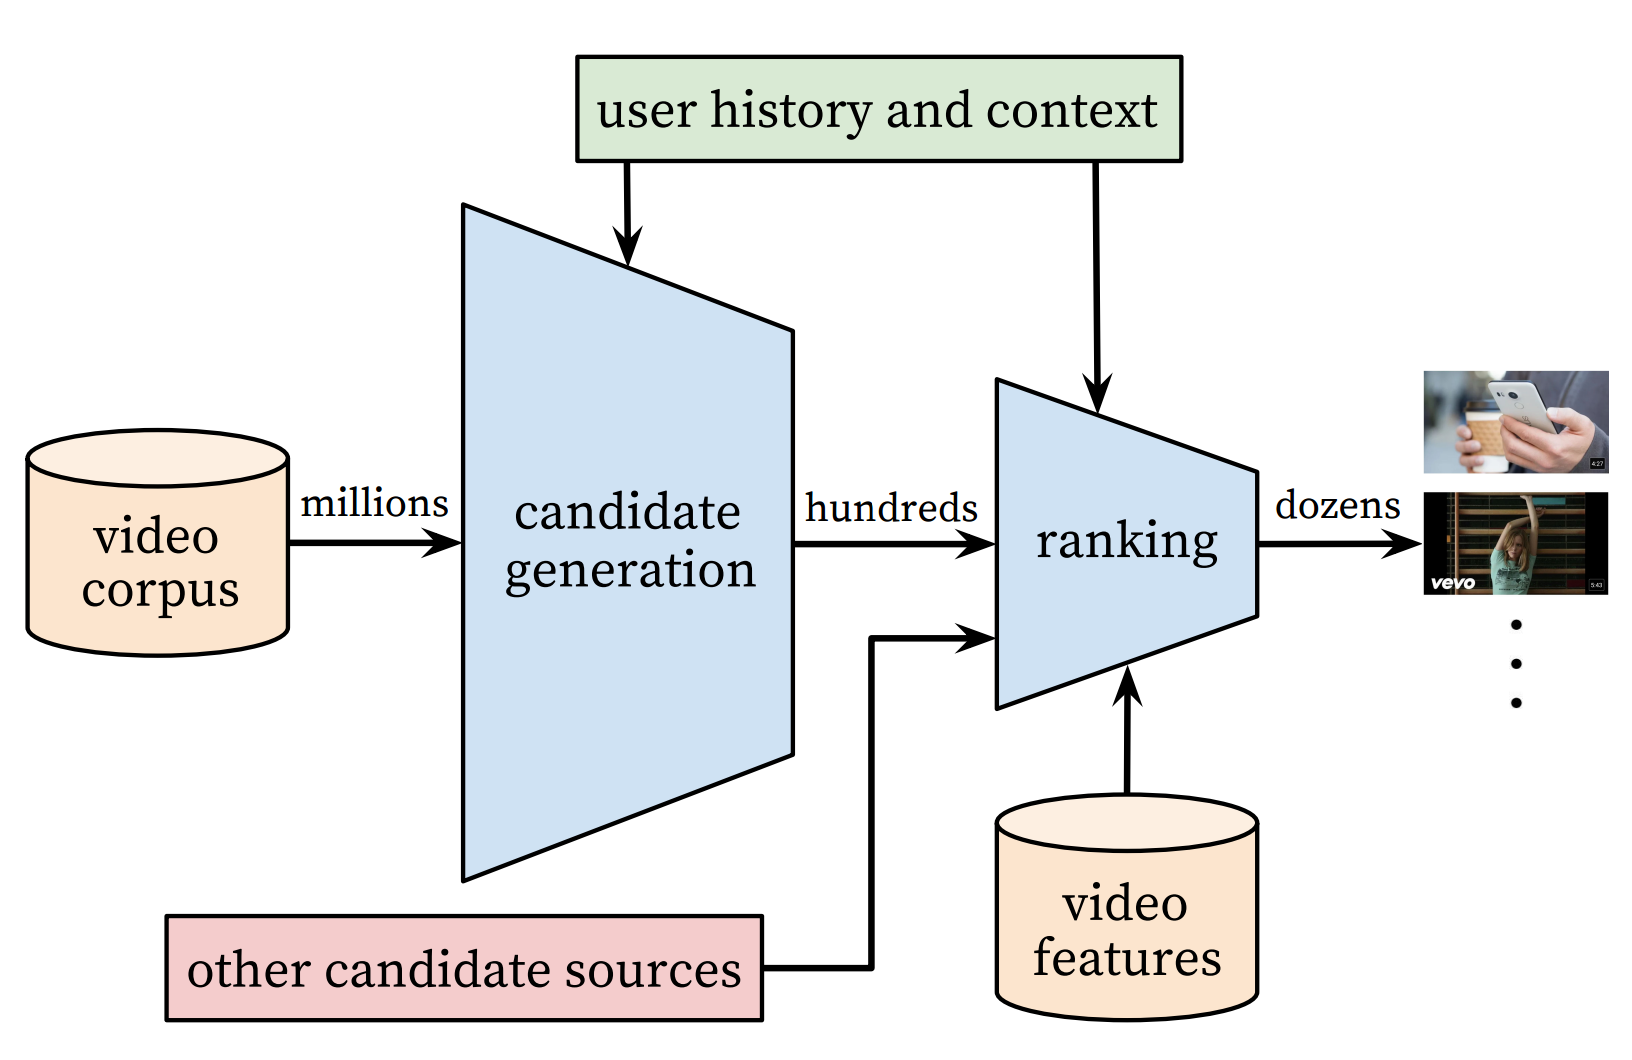

**YouTube recommender system overview**

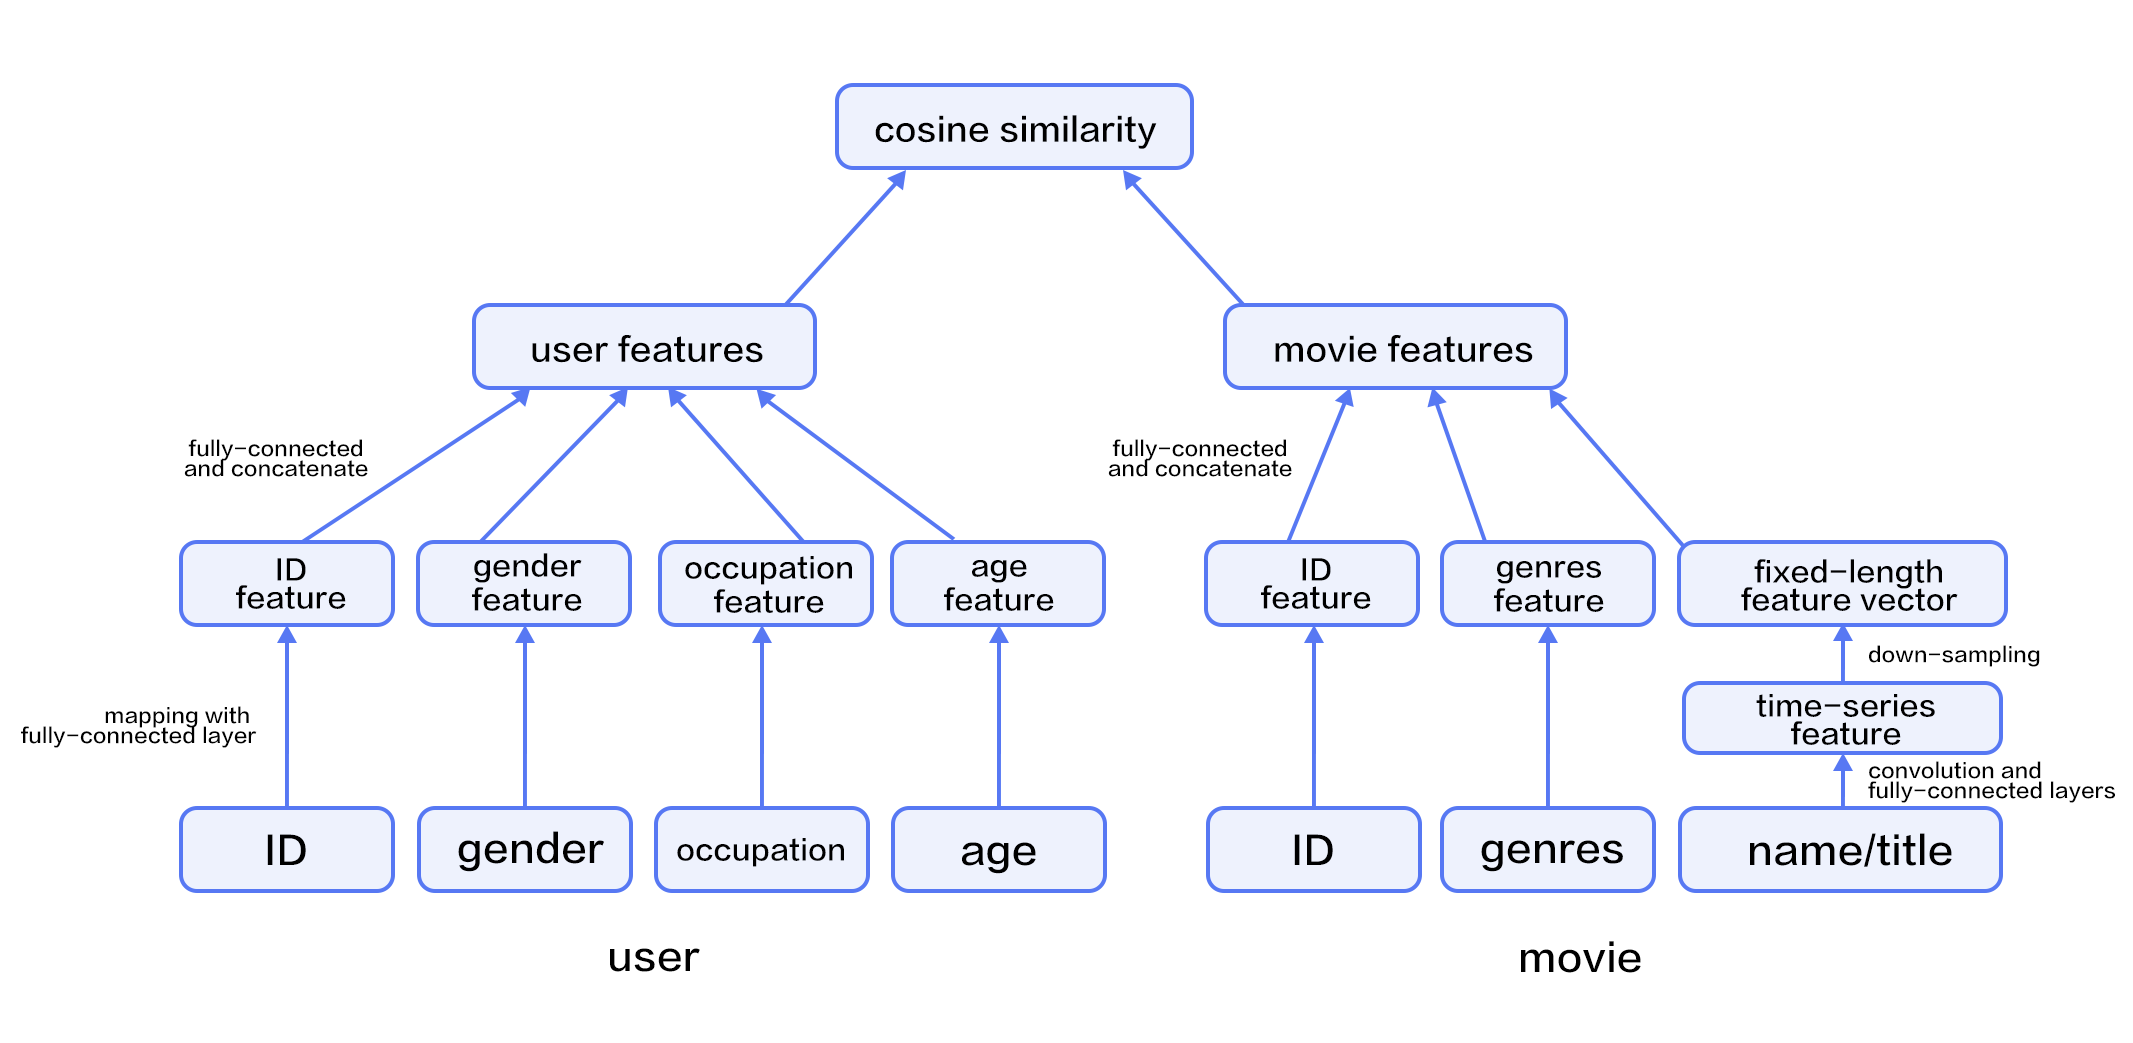
** A hybrid recommendation model**

In [1]:
import paddle.v2 as paddle
movie_info = paddle.dataset.movielens.movie_info()
print movie_info.values()[0]

Cache file /home/xin/.cache/paddle/dataset/movielens/ml-1m.zip not found, downloading http://files.grouplens.org/datasets/movielens/ml-1m.zip
[==================================================]<MovieInfo id(1), title(Toy Story ), categories(['Animation', "Children's", 'Comedy'])>


In [2]:
user_info = paddle.dataset.movielens.user_info()
print user_info.values()[0]

<UserInfo id(1), gender(F), age(1), job(10)>


In [3]:
train_set_creator = paddle.dataset.movielens.train()
train_sample = next(train_set_creator())
uid = train_sample[0]
mov_id = train_sample[len(user_info[uid].value())]
print "User %s rates Movie %s with Score %s"%(user_info[uid], movie_info[mov_id], train_sample[-1])

User <UserInfo id(1), gender(F), age(1), job(10)> rates Movie <MovieInfo id(1193), title(One Flew Over the Cuckoo's Nest ), categories(['Drama'])> with Score [5.0]


In [4]:
# model architecture
import paddle.v2 as paddle
paddle.init(use_gpu=False)

In [5]:
uid = paddle.layer.data(
    name='user_id',
    type=paddle.data_type.integer_value(
        paddle.dataset.movielens.max_user_id() + 1))
usr_emb = paddle.layer.embedding(input=uid, size=32)
usr_fc = paddle.layer.fc(input=usr_emb, size=32)

usr_gender_id = paddle.layer.data(
    name='gender_id', type=paddle.data_type.integer_value(2))
usr_gender_emb = paddle.layer.embedding(input=usr_gender_id, size=16)
usr_gender_fc = paddle.layer.fc(input=usr_gender_emb, size=16)

usr_age_id = paddle.layer.data(
    name='age_id',
    type=paddle.data_type.integer_value(
        len(paddle.dataset.movielens.age_table)))
usr_age_emb = paddle.layer.embedding(input=usr_age_id, size=16)
usr_age_fc = paddle.layer.fc(input=usr_age_emb, size=16)

usr_job_id = paddle.layer.data(
    name='job_id',
    type=paddle.data_type.integer_value(
        paddle.dataset.movielens.max_job_id() + 1))
usr_job_emb = paddle.layer.embedding(input=usr_job_id, size=16)
usr_job_fc = paddle.layer.fc(input=usr_job_emb, size=16)

In [6]:
usr_combined_features = paddle.layer.fc(
        input=[usr_fc, usr_gender_fc, usr_age_fc, usr_job_fc],
        size=200,
        act=paddle.activation.Tanh())

In [7]:
mov_id = paddle.layer.data(
    name='movie_id',
    type=paddle.data_type.integer_value(
        paddle.dataset.movielens.max_movie_id() + 1))
mov_emb = paddle.layer.embedding(input=mov_id, size=32)
mov_fc = paddle.layer.fc(input=mov_emb, size=32)

mov_categories = paddle.layer.data(
    name='category_id',
    type=paddle.data_type.sparse_binary_vector(
        len(paddle.dataset.movielens.movie_categories())))
mov_categories_hidden = paddle.layer.fc(input=mov_categories, size=32)

movie_title_dict = paddle.dataset.movielens.get_movie_title_dict()
mov_title_id = paddle.layer.data(
    name='movie_title',
    type=paddle.data_type.integer_value_sequence(len(movie_title_dict)))
mov_title_emb = paddle.layer.embedding(input=mov_title_id, size=32)
mov_title_conv = paddle.networks.sequence_conv_pool(
    input=mov_title_emb, hidden_size=32, context_len=3)

mov_combined_features = paddle.layer.fc(
    input=[mov_fc, mov_categories_hidden, mov_title_conv],
    size=200,
    act=paddle.activation.Tanh())

In [9]:
inference = paddle.layer.cos_sim(a=usr_combined_features, b=mov_combined_features, size=1, scale=5)
cost = paddle.layer.square_error_cost(
        input=inference,
        label=paddle.layer.data(
        name='score', type=paddle.data_type.dense_vector(1)))


In [10]:
# Create parameters
parameters = paddle.parameters.create(cost)

In [11]:
trainer = paddle.trainer.SGD(cost=cost, parameters=parameters,
                             update_equation=paddle.optimizer.Adam(learning_rate=1e-4))

In [12]:
reader=paddle.batch(
    paddle.reader.shuffle(
        paddle.dataset.movielens.train(), buf_size=8192),
        batch_size=256)

In [13]:
feeding = {
    'user_id': 0,
    'gender_id': 1,
    'age_id': 2,
    'job_id': 3,
    'movie_id': 4,
    'category_id': 5,
    'movie_title': 6,
    'score': 7
}

In [14]:
def event_handler(event):
    if isinstance(event, paddle.event.EndIteration):
        if event.batch_id % 100 == 0:
            print "Pass %d Batch %d Cost %.2f" % (
                event.pass_id, event.batch_id, event.cost)

In [15]:
from paddle.v2.plot import Ploter

train_title = "Train cost"
test_title = "Test cost"
cost_ploter = Ploter(train_title, test_title)

step = 0

def event_handler_plot(event):
    global step
    if isinstance(event, paddle.event.EndIteration):
        if step % 10 == 0:  # every 10 batches, record a train cost
            cost_ploter.append(train_title, step, event.cost)

        if step % 1000 == 0: # every 1000 batches, record a test cost
            result = trainer.test(
                reader=paddle.batch(
                    paddle.dataset.movielens.test(), batch_size=256),
                feeding=feeding)
            cost_ploter.append(test_title, step, result.cost)

        if step % 100 == 0: # every 100 batches, update cost plot
            cost_ploter.plot()

        step += 1

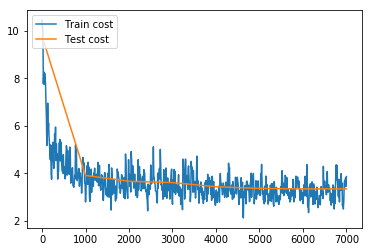

In [16]:
trainer.train(
    reader=reader,
    event_handler=event_handler_plot,
    feeding=feeding,
    num_passes=2)


`summary`
- all images are normalized, meaning that they are both rescaled and centered.
- 

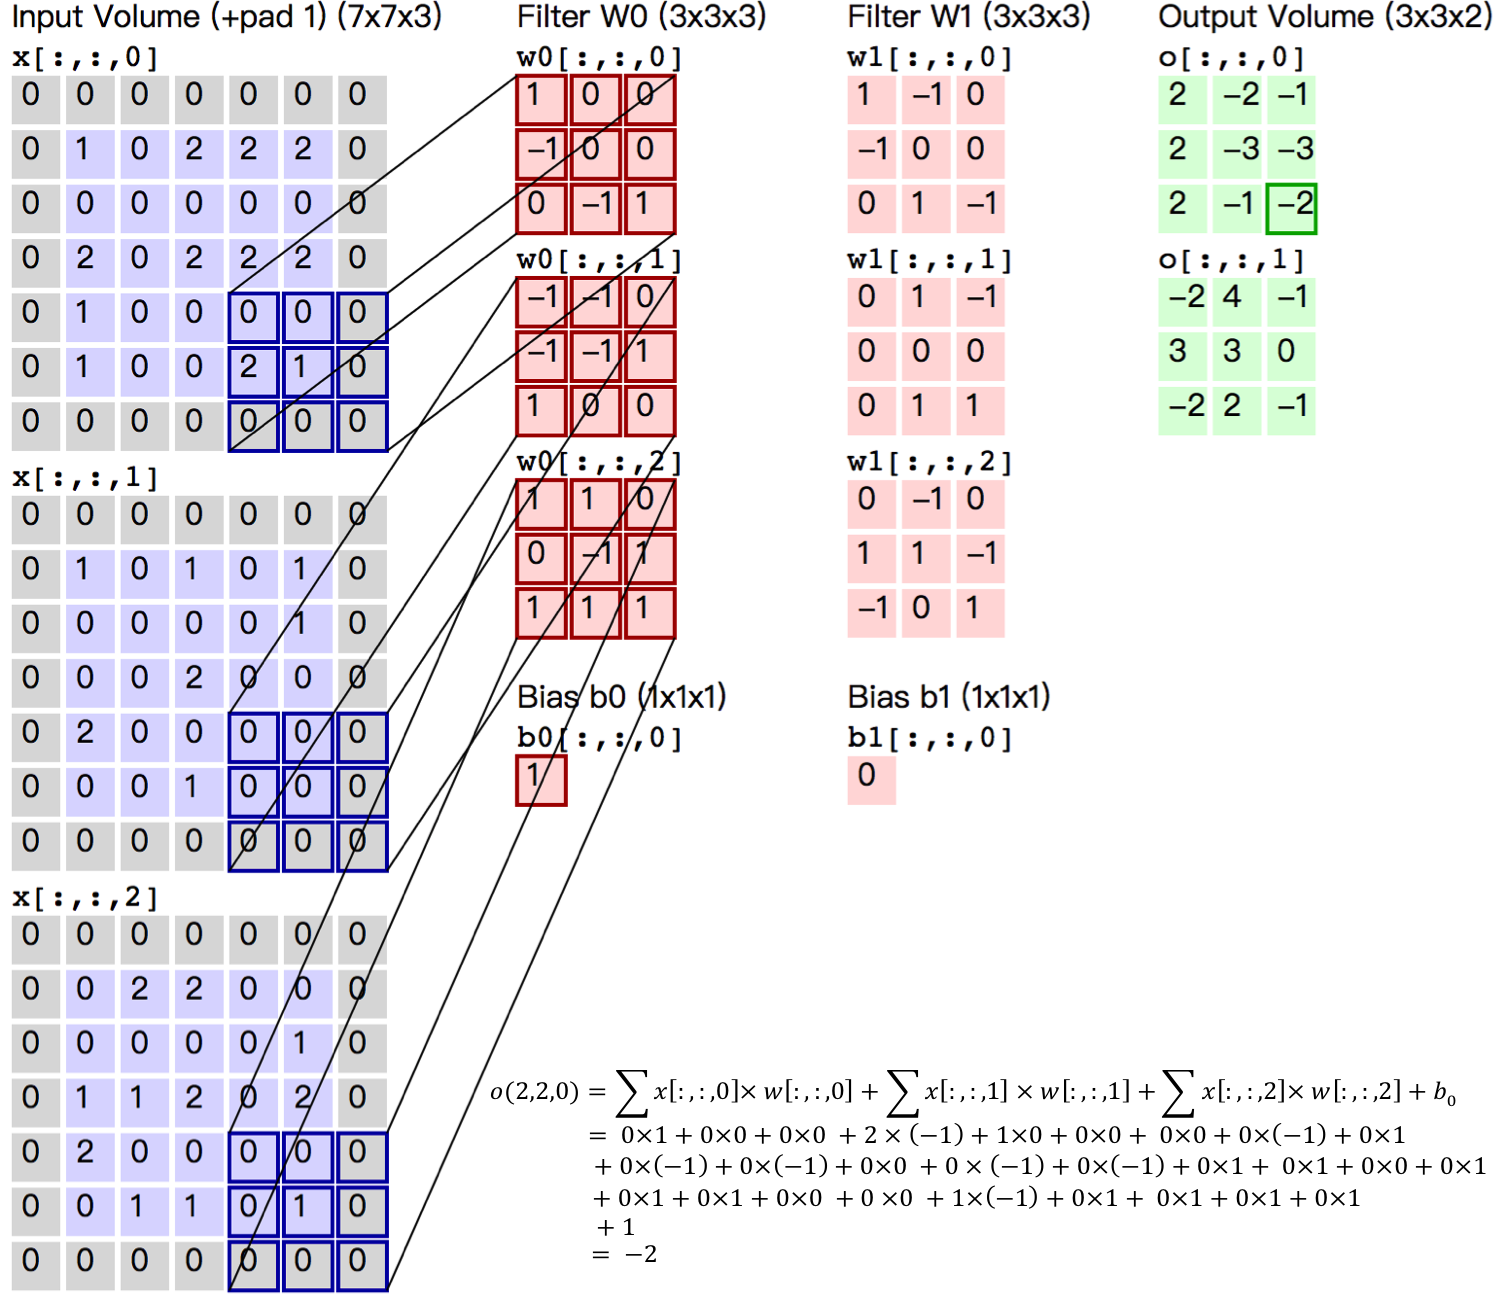




